# Initial Imports

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

df = pd.read_csv("./kieranFeatures_1-30_26-Sep-2024.csv")
df.head()

,ID,EDA_TonicMean_version02,EDA_TonicMean_version03,EDA_TonicMean_version04,EDA_TonicMean_version05,EDA_TonicMean_version09,EDA_TonicMean_version10,EDA_TonicMean_version11,EDA_TonicMean_version12,EDA_TonicMean_version16,...,EEG_avgRelTheta_version16,EEG_avgRelTheta_version17,EEG_avgRelTheta_version19,EEG_avgRelTheta_version20,EEG_avgRelTheta_version22,EEG_avgRelTheta_version23,adjSA1,adjSA2,adjSA3,adjSAtotal
0,5,-0.123031,-0.226077,-1.220480,-1.697738,-0.273200,-0.601171,-0.809518,-1.012558,-0.299118,...,-1.877017,-1.442056,1.070298,1.277417,0.249605,0.400156,0.119790,1.593122,-0.800726,0.350233
1,5,-0.152896,-0.050866,1.527067,1.883468,-0.378060,-0.018812,1.023216,1.189124,-0.355315,...,-1.632698,-1.531970,1.779032,1.074498,0.409991,0.333842,0.075246,-1.663383,0.859309,-0.262893
2,5,-0.166035,-0.181478,1.634437,0.904620,-0.424192,-0.452936,1.123414,0.534554,-0.380039,...,-1.489450,-1.448590,2.194570,1.262672,0.504028,0.395338,-1.072729,0.879836,-1.542415,-0.938513
3,5,-0.231095,-0.209571,1.654951,1.247081,-0.652624,-0.546311,1.214370,0.821624,-0.502463,...,-1.353433,-1.059878,2.589134,2.139926,0.593317,0.682023,-0.643181,-0.217332,0.945816,0.145041
4,5,-0.236090,-0.323013,-0.478244,-1.080788,-0.670161,-0.923364,-0.421866,-0.775114,-0.511862,...,-1.443846,-0.627980,2.326862,3.114644,0.533965,1.000560,-0.323098,0.712401,-1.473404,-0.642872


# Shuffling Values of All Non-Selected Features

## Pre-Processing

Divide up dataframe into predictors and outcomes. Train-test-split the following data.

Add a column for the calculated synthetic data

In [20]:
import random

# Function to calculate synthetic outcome values
def func_val_bin(predictors):
    """
        Creates a function out of five variables in the predictors dataframe
        and outputs a boolean Pandas series where True means the function value
        was greater than or equal to the median and False otherwise.

        Parameters:
            predictors (Dataframe): pandas Dataframe containing all predictor features

        Output:
            (Series): pandas Series containing True and False values where True means that
                      the calculated value was above the median and False otherwise
    """

    # Initialize array to store continuous values of function
    func_calcs = np.array([])

    # Get random coefficients and features
    random.seed(42)
    coefficients = np.array([round(random.uniform(-5, 5), 1) for _ in range(5)])
    selected_features = np.array(random.sample(list(predictors.columns), 5))

    print("Function = 1/(1+e^{-(" + 
            f"{coefficients[0]} * {selected_features[0]} + " +
            f"{coefficients[1]} * {selected_features[1]} + " +
            f"{coefficients[2]} * {selected_features[2]} + " +
            f"{coefficients[3]} * {selected_features[3]} + " +
            f"{coefficients[4]} * {selected_features[4]}" + 
            ")})")
    
    for index, row in predictors.iterrows():
        # Add new calculation to func_calcs
        func_calcs = np.append(func_calcs, 1/(1+np.e**(-(coefficients[0] * row[selected_features[0]] +
                                              coefficients[1] * row[selected_features[1]] +
                                              coefficients[2] * row[selected_features[2]] +
                                              coefficients[3] * row[selected_features[3]] +
                                              coefficients[4] * row[selected_features[4]]))))

    return pd.Series(data = (func_calcs >= 0.5).astype(int)), selected_features

In [23]:
# Create the outcome feature
synthetic_vals, selected_features = func_val_bin(df)
df["synthetic_outcome"] = synthetic_vals

Function = 1/(1+e^{-(1.4 * fNIRS_S8D6_hbr_timeToMax_version12 + -4.7 * fNIRS_S6D6_hbr_kurtosis_version17 + -2.2 * EEG_p100_poz_version11 + -2.8 * fNIRS_S7D5_hbo_kurtosis_version03 + 2.4 * fNIRS_S5D3_hbr_kurtosis_version11)})


In [24]:
predictors_df = df.iloc[:, 1:(df.shape[1] - 5)]
outcomes_df = df.iloc[:, (df.shape[1] - 5):]

# Randomize data in all non-selected feature columns
for col in predictors_df.columns:
    # Don't randomize selected features
    if col in selected_features:
        continue

    predictors_df[col] = np.random.permutation(predictors_df[col].values)

display(predictors_df)
display(outcomes_df)

# Split into train and test
predictors_train, predictors_test, outcomes_train, outcomes_test = train_test_split(predictors_df, outcomes_df, test_size = 0.2, random_state = 42)

display(predictors_train)
display(outcomes_train)

# Scale the data
scaler = StandardScaler()
predictors_train = scaler.fit_transform(predictors_train)
predictors_train = pd.DataFrame(predictors_train, columns = predictors_df.columns)
predictors_test = scaler.transform(predictors_test)
predictors_test = pd.DataFrame(predictors_test, columns = predictors_df.columns)

display(predictors_train)

# Free up memory
del df
del predictors_df
del outcomes_df

,EDA_TonicMean_version02,EDA_TonicMean_version03,EDA_TonicMean_version04,EDA_TonicMean_version05,EDA_TonicMean_version09,EDA_TonicMean_version10,EDA_TonicMean_version11,EDA_TonicMean_version12,EDA_TonicMean_version16,EDA_TonicMean_version17,...,EEG_avgRelTheta_version09,EEG_avgRelTheta_version10,EEG_avgRelTheta_version11,EEG_avgRelTheta_version12,EEG_avgRelTheta_version16,EEG_avgRelTheta_version17,EEG_avgRelTheta_version19,EEG_avgRelTheta_version20,EEG_avgRelTheta_version22,EEG_avgRelTheta_version23
0,0.012822,-0.416788,-0.704162,0.016441,-0.365210,0.453263,0.126973,-0.237457,-0.103915,-0.533249,...,-0.140859,0.552955,0.278096,0.676488,-0.320605,1.189590,-0.312717,-0.505705,1.864835,-0.628527
1,-0.007689,3.483298,-0.216242,1.693930,-0.004899,-0.328826,-0.612785,-0.473730,-0.166883,0.000000,...,-0.355901,1.254154,-0.015860,-0.582439,-0.590692,-1.629689,0.271118,2.585835,-1.346976,0.381893
2,-0.739434,-0.501785,1.011080,0.009381,-0.449432,0.984819,0.284838,-0.149024,-0.558297,-0.097964,...,-2.236782,0.167538,-0.927555,0.346639,-0.002149,-0.173218,0.105745,0.094431,-0.599893,-0.212018
3,-0.354384,3.658397,-0.328634,-0.866528,-0.004807,1.331609,0.593198,-0.990292,-0.161187,-0.315683,...,1.063605,-3.053046,1.224810,-0.744128,-0.307295,0.234313,-3.332147,-2.522525,-0.854538,0.200101
4,-0.733113,0.586161,0.000000,-0.437125,-1.407872,0.054983,-0.048732,-0.811792,0.418093,-0.530534,...,-1.231899,0.410830,-0.529614,-0.145746,0.249210,-0.487681,0.345635,0.798785,0.532665,0.967764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,-0.598078,-0.390531,-0.450103,-1.017841,1.233320,3.522785,-0.560103,-0.126197,-0.289149,-0.152899,...,-0.288472,1.827563,1.572345,0.435968,0.872790,0.674919,-0.649638,-0.374913,0.269036,0.551399
300,0.224112,0.543684,0.884390,0.198192,-0.500100,-0.300991,-0.027186,0.129104,-0.254102,-0.382328,...,0.983117,0.160554,-1.047351,1.053314,-0.539889,-1.405018,0.061110,0.552190,-0.334424,1.902183
301,-0.054260,-0.197166,-0.621228,-0.515195,0.045195,-1.211518,-0.306500,0.018082,0.209721,-0.199617,...,1.039271,-0.133419,0.030269,-0.555496,0.169580,0.816828,-1.230679,-0.463581,-0.045654,-1.598365
302,-0.040642,-0.282184,-0.100554,-0.466908,2.704038,0.215096,0.490540,0.180223,1.201976,0.194834,...,0.975978,0.237272,0.673080,-0.495113,0.997935,0.018829,0.080233,-1.281584,0.701455,-0.375448


,adjSA1,adjSA2,adjSA3,adjSAtotal,synthetic_outcome
0,0.119790,1.593122,-0.800726,0.350233,1
1,0.075246,-1.663383,0.859309,-0.262893,1
2,-1.072729,0.879836,-1.542415,-0.938513,1
3,-0.643181,-0.217332,0.945816,0.145041,1
4,-0.323098,0.712401,-1.473404,-0.642872,1
...,...,...,...,...,...
299,0.076099,1.105227,-0.609431,0.209332,0
300,-0.258249,-0.360422,0.778641,0.155357,1
301,0.110240,0.092504,0.945232,0.627581,1
302,-1.105639,0.426616,0.328063,-0.108335,1


,EDA_TonicMean_version02,EDA_TonicMean_version03,EDA_TonicMean_version04,EDA_TonicMean_version05,EDA_TonicMean_version09,EDA_TonicMean_version10,EDA_TonicMean_version11,EDA_TonicMean_version12,EDA_TonicMean_version16,EDA_TonicMean_version17,...,EEG_avgRelTheta_version09,EEG_avgRelTheta_version10,EEG_avgRelTheta_version11,EEG_avgRelTheta_version12,EEG_avgRelTheta_version16,EEG_avgRelTheta_version17,EEG_avgRelTheta_version19,EEG_avgRelTheta_version20,EEG_avgRelTheta_version22,EEG_avgRelTheta_version23
269,-0.004478,-0.296439,0.291263,-0.027784,-0.424192,0.044597,0.383287,-0.272376,-0.158862,-1.029447,...,0.410908,-0.306810,2.125386,1.223240,-0.461088,0.008128,-0.167925,0.925339,-1.076381,0.920460
211,-0.779110,3.447829,0.333107,-0.320344,-1.396764,0.243619,0.195744,-0.029013,-0.282806,-0.268734,...,-0.066389,0.271901,-0.187972,-0.061929,0.124738,3.146601,-0.661742,-3.840152,0.518098,0.516509
197,0.063175,-0.351993,-0.366936,-0.914811,0.000000,0.308968,0.282758,-0.045087,-0.189088,-0.136151,...,-0.260123,-0.333163,0.195292,-0.698929,0.507635,-0.431520,-0.587280,0.427443,0.572984,0.474066
75,0.117180,1.039846,0.509620,0.055600,-0.624705,0.103524,-0.236083,0.049359,0.389764,-0.361357,...,0.763694,-1.420337,1.030135,0.775843,0.007059,0.412261,-0.640743,-1.574889,-1.436534,-0.794811
177,-0.325386,-0.820564,0.581645,-0.563344,-1.119621,-3.171786,-0.762099,-1.012558,-0.054422,-0.409463,...,1.139064,0.385377,0.813855,-0.379276,0.118412,-0.251355,-1.110239,-0.113208,0.275224,-0.282644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,0.834268,-0.385206,-0.125706,-0.397122,0.029509,-0.025531,1.096324,0.000000,-0.012802,-0.545149,...,0.962391,-0.306750,-0.418917,-0.047756,0.967351,-0.576016,-0.823747,0.739829,0.674976,0.989332
71,0.171929,0.026153,-1.537252,-0.573580,0.311933,1.419516,-0.930341,0.130450,-1.806372,-0.661295,...,0.755186,0.547954,-0.583691,0.208789,-0.042654,0.074185,-1.201410,0.079871,1.774917,0.097127
106,0.312612,-0.730176,1.499590,-0.694283,-0.105819,0.581651,-0.654169,-0.481057,-0.171312,0.587846,...,-1.634937,1.129175,0.958044,0.355521,0.564511,-0.538994,2.023002,-3.085901,-0.796321,-0.420182
270,0.000000,-0.755155,-0.392341,2.375815,0.309768,1.423450,-0.115324,-0.329798,0.282408,-0.551082,...,0.639188,-1.264488,2.240786,-0.250041,-0.747182,-0.617142,-0.737785,3.748948,-0.497711,0.385244


,adjSA1,adjSA2,adjSA3,adjSAtotal,synthetic_outcome
269,0.143670,1.101324,-0.822506,0.117187,1
211,-0.783965,-0.834554,0.116317,-0.677632,0
197,0.475912,-0.162414,1.180378,0.804260,1
75,-0.088596,0.229732,0.972713,0.618738,0
177,-1.146056,0.662741,-3.060939,-1.932524,0
...,...,...,...,...,...
188,1.116062,0.313836,0.270247,0.799881,0
71,-0.881938,0.311514,-0.739256,-0.666210,1
106,-0.900207,0.372292,-1.423042,-1.032613,0
270,-2.025591,0.753425,0.139548,-0.472791,1


,EDA_TonicMean_version02,EDA_TonicMean_version03,EDA_TonicMean_version04,EDA_TonicMean_version05,EDA_TonicMean_version09,EDA_TonicMean_version10,EDA_TonicMean_version11,EDA_TonicMean_version12,EDA_TonicMean_version16,EDA_TonicMean_version17,...,EEG_avgRelTheta_version09,EEG_avgRelTheta_version10,EEG_avgRelTheta_version11,EEG_avgRelTheta_version12,EEG_avgRelTheta_version16,EEG_avgRelTheta_version17,EEG_avgRelTheta_version19,EEG_avgRelTheta_version20,EEG_avgRelTheta_version22,EEG_avgRelTheta_version23
0,-0.007824,-0.312446,0.303162,-0.000712,-0.398739,0.024310,0.341945,-0.300662,-0.117506,-1.052965,...,0.414148,-0.334746,2.136799,1.131520,-0.470416,0.004063,-0.181429,0.922585,-1.132090,0.928216
1,-0.815700,3.470203,0.343469,-0.300121,-1.335565,0.228192,0.160015,0.002951,-0.251208,-0.231397,...,-0.067867,0.272943,-0.146814,-0.090276,0.118196,3.058558,-0.664644,-3.733837,0.515541,0.514769
2,0.062731,-0.368570,-0.330851,-0.908504,0.009863,0.295137,0.244424,-0.017102,-0.150111,-0.088207,...,-0.263516,-0.362419,0.231522,-0.695866,0.502914,-0.423821,-0.591780,0.436085,0.572256,0.471328
3,0.119054,1.037536,0.513496,0.084624,-0.591882,0.084677,-0.258887,0.100726,0.474316,-0.331430,...,0.770423,-1.504030,1.055631,0.706185,-0.000043,0.397383,-0.644095,-1.520420,-1.504248,-0.827376
4,-0.342504,-0.841944,0.582874,-0.548810,-1.068608,-3.270620,-0.769161,-1.224092,-0.004843,-0.383384,...,1.149504,0.392101,0.842132,-0.391975,0.111840,-0.248476,-1.103511,-0.092192,0.264570,-0.303169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,0.866916,-0.402123,-0.098485,-0.378696,0.038287,-0.047530,1.033641,0.039147,0.040054,-0.529925,...,0.971084,-0.334683,-0.374789,-0.076802,0.964816,-0.564450,-0.823170,0.741321,0.677648,0.998708
239,0.176153,0.013452,-1.458164,-0.559285,0.310331,1.432806,-0.932367,0.201893,-1.894731,-0.655362,...,0.761830,0.562819,-0.537444,0.167093,-0.049992,0.068353,-1.192724,0.096468,1.814255,0.085529
240,0.322874,-0.750629,1.467089,-0.682814,-0.092067,0.574479,-0.664461,-0.561006,-0.130936,0.693708,...,-1.651923,1.173143,0.984467,0.306589,0.560060,-0.528419,1.962458,-2.996849,-0.842694,-0.443940
241,-0.003154,-0.775865,-0.355323,2.459155,0.308246,1.436837,-0.141743,-0.372299,0.358507,-0.536333,...,0.644686,-1.340379,2.250714,-0.269113,-0.757870,-0.604476,-0.739053,3.681570,-0.534130,0.380419


,adjSA1,adjSA2,adjSA3,adjSAtotal,synthetic_outcome
269,0.143670,1.101324,-0.822506,0.117187,1
211,-0.783965,-0.834554,0.116317,-0.677632,0
197,0.475912,-0.162414,1.180378,0.804260,1
75,-0.088596,0.229732,0.972713,0.618738,0
177,-1.146056,0.662741,-3.060939,-1.932524,0
...,...,...,...,...,...
188,1.116062,0.313836,0.270247,0.799881,0
71,-0.881938,0.311514,-0.739256,-0.666210,1
106,-0.900207,0.372292,-1.423042,-1.032613,0
270,-2.025591,0.753425,0.139548,-0.472791,1


## Hyperparameter Selection

In [5]:
def select_hyperparameters(model, predictors, outcome, params, eval_metric):
    """
        Conducts GridSearchCV on a Logistic Regression model to identify suitable hyperparameters

        Parameters:
            model (sklearn Model): sklearn Model to conduct GridSearchCV on
            predictors (Dataframe): pandas Dataframe containing all predictor features
            outcome (Series): pandas Series containing all values for the outcome variable
            params (dictionary): Dictionary of parameters for GridSearchCV for a LogisticRegression model
            eval_metric (string): Name of evaluation metric to use for GridSearchCV

        Return:
            clf (GridSearchCV): GridSearchCV object after running GridSearchCV with provided parameters
    """
    
    # Perform 5-fold cross-validation with different regularization strengths and regularization types
    clf = GridSearchCV(model, params, cv = 5, scoring = eval_metric, n_jobs = -1)
    clf.fit(predictors, outcome)

    # Show the best regularization strength and penaalty type
    print("Best regularization strength:", clf.best_params_["C"])
    print("Best l1_ratio:", clf.best_params_["l1_ratio"])

    return clf

In [6]:
params = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100],
    "l1_ratio": [0, 0.1, 0.5, 0.9, 1]
}

SA_func_Log_Reg = LogisticRegression(solver = "saga", penalty = "elasticnet", max_iter = 10000, fit_intercept = False)
SA_GridSearchCV_func = select_hyperparameters(SA_func_Log_Reg, predictors_train, outcomes_train["synthetic_outcome"], params, "accuracy")

Best regularization strength: 0.1
Best l1_ratio: 1


In [8]:
print(np.sum(SA_GridSearchCV_func.best_estimator_.coef_ != 0))
print(SA_GridSearchCV_func.best_score_)

67
0.8354591836734695


## Fit Actual Model with Training Data

In [26]:
SA_model_func = LogisticRegression(max_iter = 15000, penalty = "elasticnet", solver = "saga", C = 0.1, l1_ratio = 1, n_jobs = -1, fit_intercept = False)
SA_model_func.fit(predictors_train, outcomes_train["synthetic_outcome"])
SA_model_func

LogisticRegression(C=0.1, fit_intercept=False, l1_ratio=1, max_iter=15000,
                   n_jobs=-1, penalty='elasticnet', solver='saga')

In [27]:
np.sum(SA_model_func.coef_ != 0)

np.int64(66)

In [28]:
SA_model_func_coef = pd.DataFrame(
    data = {
        "coefficients": SA_model_func.coef_[0]
    },
    index = np.array(list(predictors_test.columns))
)

display(SA_model_func_coef.loc[selected_features, :])
display(SA_model_func_coef[SA_model_func_coef["coefficients"] != 0])

,coefficients
fNIRS_S8D6_hbr_timeToMax_version12,0.104446
fNIRS_S6D6_hbr_kurtosis_version17,-1.404350
EEG_p100_poz_version11,0.000000
fNIRS_S7D5_hbo_kurtosis_version03,-0.980910
fNIRS_S5D3_hbr_kurtosis_version11,0.021495


,coefficients
ECG_SDNN_version04,0.000153
EYE_BlinkRate_version12,0.034345
EEG_avgRelFroAlpha_version09,0.017653
EEG_avgRelOccDelta_version10,0.077428
EEG_avgRelParDelta_version12,-0.045260
...,...
fNIRS_S8D6_hbr_slope_version03,0.014012
fNIRS_S8D6_hbr_MaxAmp_version23,-0.010613
fNIRS_S8D6_hbr_timeToMax_version12,0.104446
fNIRS_S8D7_hbo_area_version19,0.060378


## Evaluate Model Performance

In [29]:
def get_eval_metrics(model, predictors, outcome):
    """
        Plots confusion matrix and ROC-AUC curve for a fitted sklearn model

        Parameters:
            model (sklearn Model): sklearn model to predict outcome values
            predictors (DataFrame): pandas Dataframe containing all predictor features
            outcome (Series): pandas Series containing all values for the outcome variable
            display_labels (list(str)): List of 2 strings for labeling the 0 and 1 outputs for confusion matrix

        Return:
            None
    """
    
    predicted_outcomes = model.predict(predictors)
    print("Accuracy: ", accuracy_score(predicted_outcomes, outcome))

    # Confusion Matrix
    cm = metrics.confusion_matrix(outcome, predicted_outcomes)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
    cm_display.plot()
    plt.show()

    # ROC Curve
    fpr, tpr, thresholds = metrics.roc_curve(outcome, predicted_outcomes)
    roc_auc  = metrics.auc(fpr, tpr)

    plt.plot(fpr, tpr, label = "ROC Curve (area = %0.3f)" % roc_auc)
    plt.plot([0, 1], [0, 1], "k--") # Random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

Accuracy:  0.9672131147540983


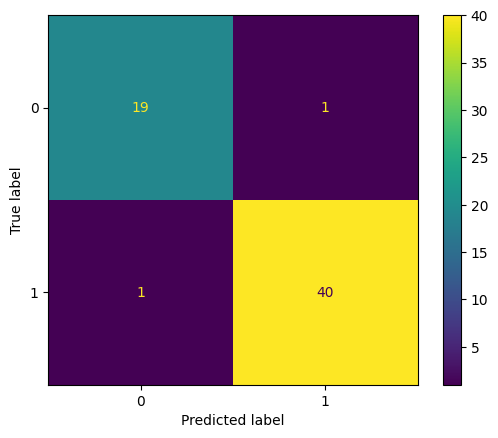

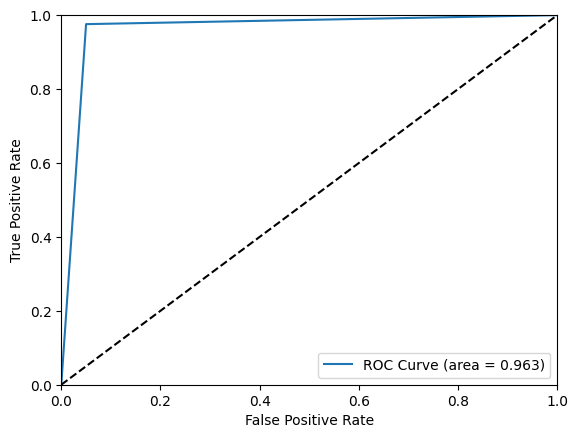

In [30]:
get_eval_metrics(SA_model_func, predictors_test, outcomes_test["synthetic_outcome"])